In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import utils
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]
n_rounds = len(round_ids)

In [3]:
dtype = torch.float32
device = torch.device('cpu')

In [4]:
sequences, sequences_unique, counts, log_multinomial_factors = utils.sequences_counts_from_files(experiment_id, round_ids)

Finished round ARN
Finished round R01
Finished round R02N


In [5]:
sequences_oh = [utils.one_hot(s) for s in sequences]

In [7]:
fi_tuple, fij_tuple, total_reads_tuple = zip(*[utils.frequences_from_sequences_oh(s) for s in sequences_oh])
fi = torch.stack(fi_tuple)
_, L, q = fi.size()
total_reads = torch.tensor(total_reads_tuple)
log_likelihood_normaliz = (total_reads + log_multinomial_factors).sum().item()

In [22]:
model = torch.load(f'saved/{experiment_id}.pt', weights_only=False, map_location='cpu')

In [23]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
batches = [next(iter(dl)) for dl in data_loaders]

In [24]:
from importlib import reload
reload(training)

<module 'training' from '/home/scrotti/Aptamer2025py/experiments/../training.py'>

### Prepare two sets of chains, initialized differently, compute mixing times

In [85]:
n_chains = 10**4
chains_fi = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device, fi=fi)
chains_indep = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Mixing time not reached within 500 sweeps.


[50, 67, 500]

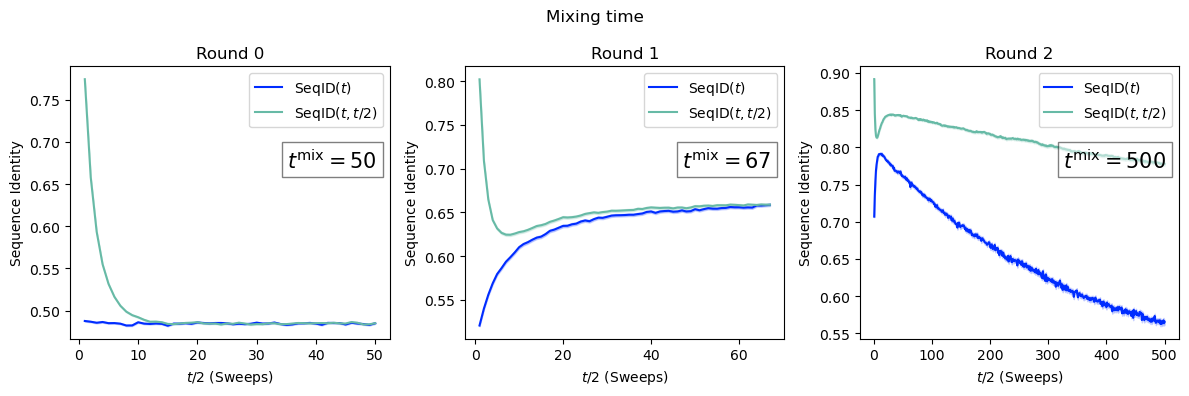

In [86]:
n_max_sweeps = 10**3

mixing_times_fi, fig_fi = sampling.compute_and_plot_mixing_time(model, chains_fi, n_max_sweeps)

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

Mixing time not reached within 500 sweeps.


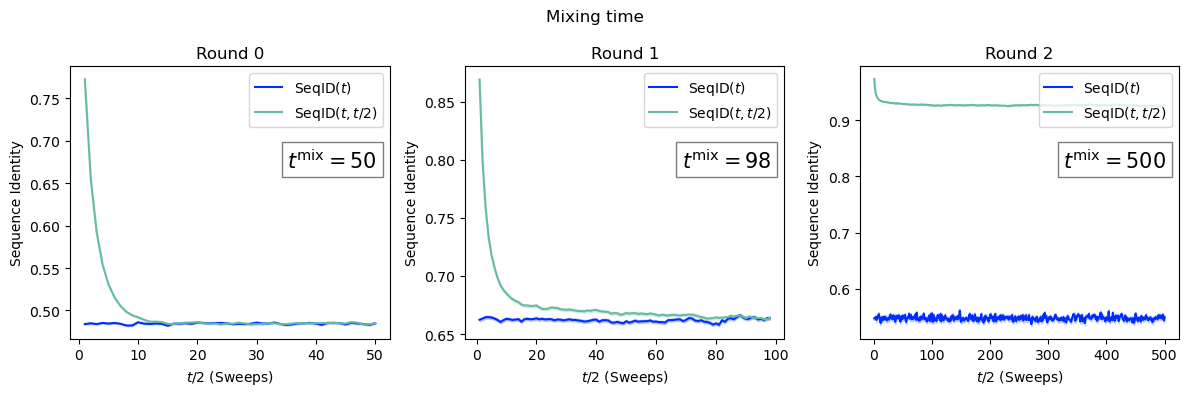

In [89]:
n_max_sweeps = 10**3

mixing_times_indep, fig_indep = sampling.compute_and_plot_mixing_time(model, chains_indep, n_max_sweeps)

### Thermalize

In [106]:
chains_fi = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device, fi=fi)
chains_indep = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)

In [107]:
model.sample(chains_fi, n_sweeps=100);

In [108]:
model.sample(chains_indep, n_sweeps=100);

### Compute moments

In [109]:
L_data = 0
model.zero_grad()
for t in range(n_rounds):
    L_d = - model.compute_energy_up_to_round(batches[t].clone(), t).mean()
    L_data += total_reads[t] * L_d / log_likelihood_normaliz
grad_data = training.compute_grad_data(model, L_data, retain_graph=False)
# grad_data = torch.nn.utils.parameters_to_vector(grad_data)

In [110]:
L_model_fi = 0
model.zero_grad()
for t in range(n_rounds):
    L_m = - model.compute_energy_up_to_round(chains_fi[t].clone(), t).mean()
    L_model_fi += total_reads[t] * L_m / log_likelihood_normaliz
grad_model_fi = training.compute_grad_data(model, L_model_fi, retain_graph=False)
# grad_model_fi = torch.nn.utils.parameters_to_vector(grad_model_fi)

In [111]:
L_model_indep = 0
model.zero_grad()
for t in range(n_rounds):
    L_m = - model.compute_energy_up_to_round(chains_indep[t].clone(), t).mean()
    L_model_indep += total_reads[t] * L_m / log_likelihood_normaliz
grad_model_indep = training.compute_grad_data(model, L_model_indep, retain_graph=False)
# grad_model_indep = torch.nn.utils.parameters_to_vector(grad_model_indep)

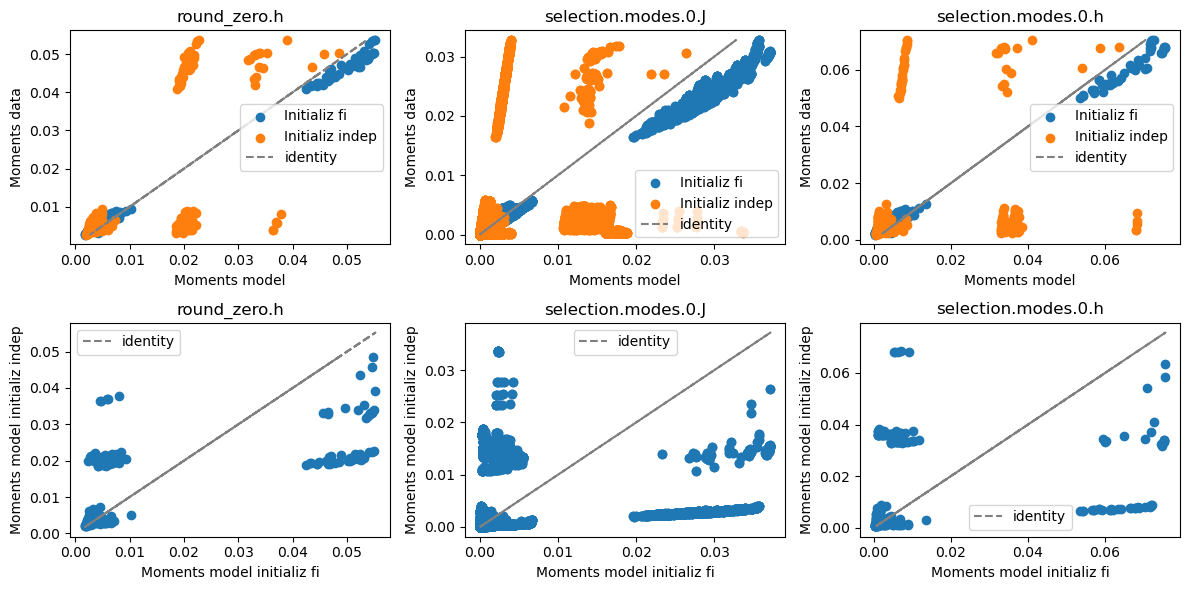

In [112]:
n_param = len(list(model.named_parameters()))

fig, axes = plt.subplots(2, n_param, figsize=(12,6))
for (i, (param_name, _)) in enumerate(model.named_parameters()):
    ax = axes[0, i]
    ax.scatter(grad_model_fi[i], grad_data[i], label='Initializ fi')
    ax.scatter(grad_model_indep[i], grad_data[i], label='Initializ indep')
    ax.plot(grad_data[i].reshape(-1), grad_data[i].reshape(-1), label='identity', color='gray', ls='--')
    ax.legend()
    ax.set_xlabel('Moments model')
    ax.set_ylabel('Moments data')
    ax.set_title(param_name)

    ax = axes[1, i]
    ax.scatter(grad_model_fi[i], grad_model_indep[i])
    ax.plot(grad_model_fi[i].reshape(-1), grad_model_fi[i].reshape(-1), label='identity', color='gray', ls='--')
    ax.legend()
    ax.set_xlabel('Moments model initializ fi')
    ax.set_ylabel('Moments model initializ indep')
    ax.set_title(param_name)
fig.tight_layout()